<a href="https://colab.research.google.com/github/guillermohenrion/Intro-Python/blob/master/Preparaci%C3%B3n_y_evaluaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Frontreas de decisión en árboles
* Particionamiento en función de lo que se quiere generalizar
* CV y CV estratificado
* Métricas con y sin desbalanceo: F1, F$\beta$, ROC, AUC, matriz de confusión, 
lift, ordenar por percentiles
* Calibración 



#Frontreas de decisión en árboles


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def dataset_sintetico_gausianas(means,covs,points,labels,seed=1234):
  all_dfs = []
  np.random.seed(seed)
  for mean_i,cov_i,points_i,label_i in zip(means,covs,points,labels):
    features_i = np.random.multivariate_normal(mean=mean_i, cov=cov_i,size=points_i)
    dataset_i = pd.DataFrame(features_i)
    dataset_i['Clase'] = label_i
    all_dfs.append(dataset_i)
  
  return pd.concat(all_dfs)


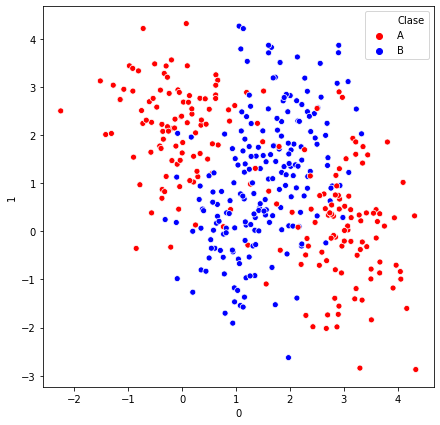

In [3]:
cov = [[0.4,0],[0,1.2]]
c1_mean = [0,2]
c2_mean = [1,0]
c3_mean = [2,2]
c4_mean = [3,0]

dataset = dataset_sintetico_gausianas([c1_mean,c2_mean,c3_mean,c4_mean],[cov,cov,cov,cov],[100,100,100,100],['A','B','B','A'])

plt.figure(figsize=(7,7))
sns.scatterplot(x=0,y=1,hue='Clase',data=dataset,palette={'A':'red','B':'blue'})

[Text(167.4, 181.2, 'X[0] <= 0.335\ngini = 0.5\nsamples = 400\nvalue = [200, 200]'),
 Text(83.7, 108.72, 'X[1] <= 0.678\ngini = 0.189\nsamples = 85\nvalue = [76, 9]'),
 Text(41.85, 36.23999999999998, 'gini = 0.496\nsamples = 11\nvalue = [5, 6]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.078\nsamples = 74\nvalue = [71, 3]'),
 Text(251.10000000000002, 108.72, 'X[0] <= 2.587\ngini = 0.477\nsamples = 315\nvalue = [124, 191]'),
 Text(209.25, 36.23999999999998, 'gini = 0.331\nsamples = 220\nvalue = [46, 174]'),
 Text(292.95, 36.23999999999998, 'gini = 0.294\nsamples = 95\nvalue = [78, 17]')]

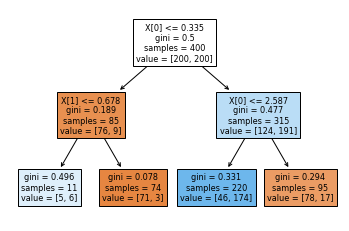

In [49]:
 from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=2)
clf2 = tree.DecisionTreeClassifier(max_depth=15)
dataset.columns=['Col1', 'Col2', 'Clase']
clf = clf.fit(dataset[['Col1', 'Col2']], dataset['Clase'])
clf2 = clf2.fit(dataset[['Col1', 'Col2']], dataset['Clase'])
tree.plot_tree(clf, filled=True)



In [0]:
#tree.plot_tree(clf2, filled=True)

In [0]:
grid = np.meshgrid(np.arange(-3,6,0.1),np.arange(-3,6,0.1))
x_vals = grid[0].reshape(-1,1)
y_vals = grid[1].reshape(-1,1)

datos_frontera = pd.DataFrame(np.concatenate([x_vals,y_vals],axis=1))
datos_frontera2 = pd.DataFrame(np.concatenate([x_vals,y_vals],axis=1))

datos_frontera['Clase_Arbol1'] =clf.predict(datos_frontera)
datos_frontera2['Clase_Arbol2'] =clf2.predict(datos_frontera2)

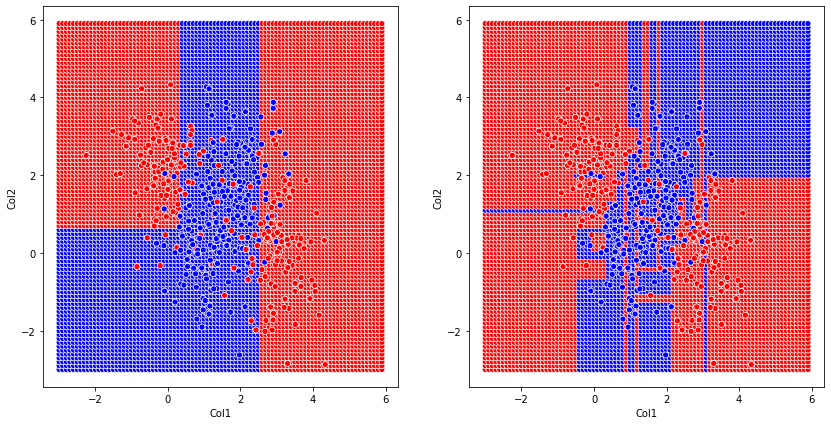

In [51]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(14,7))
sns.scatterplot(x=0,y=1,hue='Clase_Arbol1',data=datos_frontera,palette={'A':'red','B':'blue'},ax=ax[0])
sns.scatterplot(x='Col1',y='Col2',hue='Clase',data=dataset,palette={'A':'red','B':'blue'},ax=ax[0])
ax[0].get_legend().remove()

sns.scatterplot(x=0,y=1,hue='Clase_Arbol2',data=datos_frontera2,palette={'A':'red','B':'blue'},ax=ax[1])
sns.scatterplot(x='Col1',y='Col2',hue='Clase',data=dataset,palette={'A':'red','B':'blue'},ax=ax[1])
ax[1].get_legend().remove()

#División de datos Train-Validation-Test

In [0]:
from sklearn.datasets import load_breast_cancer

data_breast = load_breast_cancer()

Transformar el dataset en un dataframe:

In [0]:
df_data = pd.DataFrame(data_breast['data'],columns=data_breast['feature_names'])
df_data['target'] = data_breast['target']
features = data_breast['feature_names']
target = 'target'

Veamos qué tan balanceados están los datos:

In [57]:
df_data['target'].value_counts(normalize=True)

1    0.627417
0    0.372583
Name: target, dtype: float64

Dividamos los datos usando splits de entrenamiento, validacion y prueba. Hagamos 70, 15, 15.

In [0]:
#Con sklearn podemos dividir nuestros datos en conjuntos de entrenamiento, validación y prueba.

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_data[features].values, df_data[target].values, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test,y_test,test_size=0.5)

Podemos ver ahora como quedo

In [59]:
print('Entrenamiento: {}'.format(len(x_train)))
print('Validacion: {}'.format(len(x_val)))
print('Prueba: {}'.format(len(x_test)))

Entrenamiento: 398
Validacion: 85
Prueba: 86


Tambien podemos ver como quedaron balanceadas las clases en cada split:

In [60]:
for split_name, split in zip(['Entrenamiento','Validacion','Prueba'],[y_train,y_val,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[0]))

Entrenamiento: 0.374
Validacion: 0.400
Prueba: 0.337


Se puede observar que en cada uno de los splits, la proporción de las clases, por hacerse aleatoriamente la división, es distinta. Esto podría llegar a afectarnos. Una posibilidad es hacer splits estratificados:

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df_data[features].values, df_data[target].values, test_size=0.3, random_state=42,stratify=df_data[target].values)
x_val, x_test, y_val, y_test = train_test_split(x_test,y_test,test_size=0.5,stratify=y_test)

In [63]:
print('Entrenamiento: {}'.format(len(x_train)))
print('Validacion: {}'.format(len(x_val)))
print('Prueba: {}'.format(len(x_test)))

Entrenamiento: 398
Validacion: 85
Prueba: 86


Ahora los splits tienen mas o menos el mismo balance

In [64]:
for split_name, split in zip(['Entrenamiento','Validacion','Prueba'],[y_train,y_val,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[0]))

Entrenamiento: 0.372
Validacion: 0.376
Prueba: 0.372


Vamos a separarnos un set de evaluación



In [0]:
x_train, x_test, y_train, y_test = train_test_split(df_data[features].values, df_data[target].values, test_size=0.3, random_state=42,stratify=df_data[target].values)

### Ejercicio 1 (15 minutos)

Hacer 100 divisiones distintas train-val. Medir accuracy, precision, recall y F1. Hacer un gráfico de caja y bigotes de estas métricas.

Comparar las gráficas de dos tipos de árboles:

* Árbol sencillo: profundidad < 10, min_samples_leaf>10, ccp_alpha=0.2

* Árbol complejo: profundidad > 20, min_samples_leaf<5, ccp_alpha=0

¿Cómo varían las distribuciones? ¿Por qué?


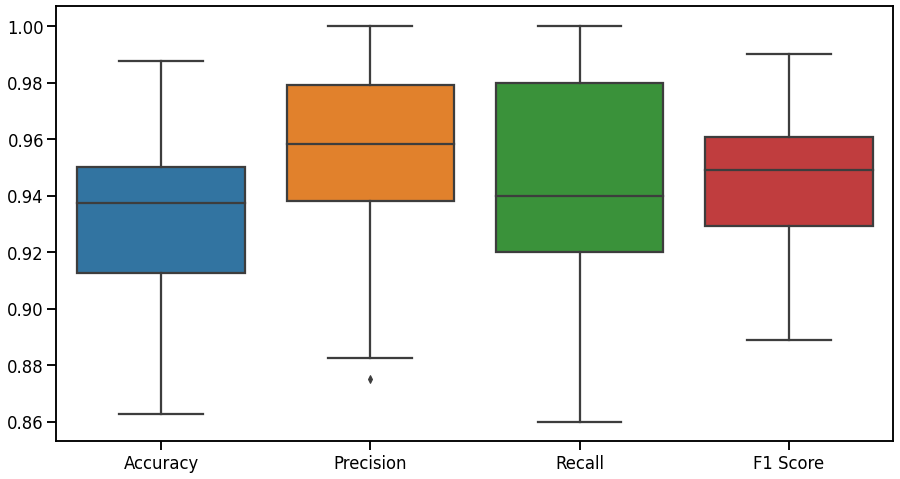

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

n_seeds = 100
accs = []
precisions = []
recalls = []
f1s = []

for seed in range(n_seeds):
  x_train_, x_val, y_train_, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=seed,stratify=y_train)
  arbol_sklearn = DecisionTreeClassifier(criterion='entropy',max_depth=20,min_samples_leaf=1, ccp_alpha=0)
  arbol_sklearn.fit(x_train_,y_train_)

  y_pred_val = arbol_sklearn.predict(x_val)
  accs.append(accuracy_score(y_val,y_pred_val))
  precisions.append(precision_score(y_val,y_pred_val))
  recalls.append(recall_score(y_val,y_pred_val))
  f1s.append(f1_score(y_val,y_pred_val))

all_metrics = accs + precisions + recalls + f1s
metric_labels = ['Accuracy']*len(accs) + ['Precision']*len(precisions) + ['Recall']*len(recalls) + ['F1 Score']*len(f1s)

sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(metric_labels,all_metrics)

Ahora queremos entrenar árboles de decisión. Teníamos varios hiperparámetros para decidir, como la profundidad, función de costo, número de instancias mínimo en una hoja, etc... Con sklearn, es posible explorar combinaciones de estos hiperparámetros asi elegimos la que mejores resultados den.

Ahora bien, tenemos que elegir una métrica en base a la cual tomar la decisión, y tenemos que tener datos en los que evaluar. En lugar de usar splits de entrenamiento-validación, vamos a usar k-fold cross-validation.

In [67]:
df_data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
